In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

In [2]:
# jedi 0.14.1 tab completion fails; will be fixed in 0.14.2
import jedi
if jedi.__version__ == '0.14.1':
    %config Completer.use_jedi = False
    
# Progress bar
from tqdm.auto import trange, tqdm

In [4]:
import pynrc
from pynrc import nrc_utils
from pynrc import nircam_dark

In [14]:
from astropy.io import fits

# NIRCam Dark Info

In [5]:
# Init NIRCam dark
datadir='/Users/jarron/NIRCam/Data/CV3_Darks/'
outdir='/Users/jarron/NIRCam/dark_analysis/CV3/'
dark_data = nircam_dark(485, datadir, outdir)

[     pynrc:INFO] Initializing SCA 485/A5


In [9]:
# Dark ramp/slope info

# Dark slope and bias images
dark_data.get_dark_slope_image()
dark_data.get_super_bias_update()

# Get IPC/PPC kernels
dark_data.get_ipc(calc_ppc=True)

# Deconvolve the super dark and super bias images
dark_data.deconvolve_supers()

[     pynrc:INFO] Calculating dark slope image...
[     pynrc:INFO] Opening updated super bias
[     pynrc:INFO] Calculating IPC and PPC kernels...
[     pynrc:INFO]   IPC = 0.597% +/- 0.004%
[     pynrc:INFO]   PPC = 0.123% +/- 0.010%
[     pynrc:INFO] Deconvolving super dark and super bias images...


# NIRCam Linearity Data

In [11]:
import os 

datadir='/Users/jarron/NIRCam/Data/CV3_Linearity/'
scaid = 485

# Directory information
indir = os.path.join(datadir, str(scaid)) + '/'
# Get file names within directory
allfits = [file for file in os.listdir(indir) if file.endswith('.fits')]
allfits = np.sort(allfits)
# Add directory 
allfiles = [indir + f for f in allfits]


In [16]:
hdr = fits.getheader(allfiles[0])

In [17]:
from pynrc.detops import create_detops

DMS=False
same_scan_direction=False
reverse_scan_direction=False

det = create_detops(hdr, DMS=DMS)

[     pynrc:INFO] Initializing SCA 485/A5


In [23]:
from pynrc.reduce import calib, ref_pixels
from pynrc.maths import robust

In [21]:
nchan = det.nout
kwargs_ref = {
    'nchans': nchan, 'in_place': True, 'altcol': True, 'perint': False,
    'fixcol': True, 'avg_type': 'pixel', 'savgol': True
}

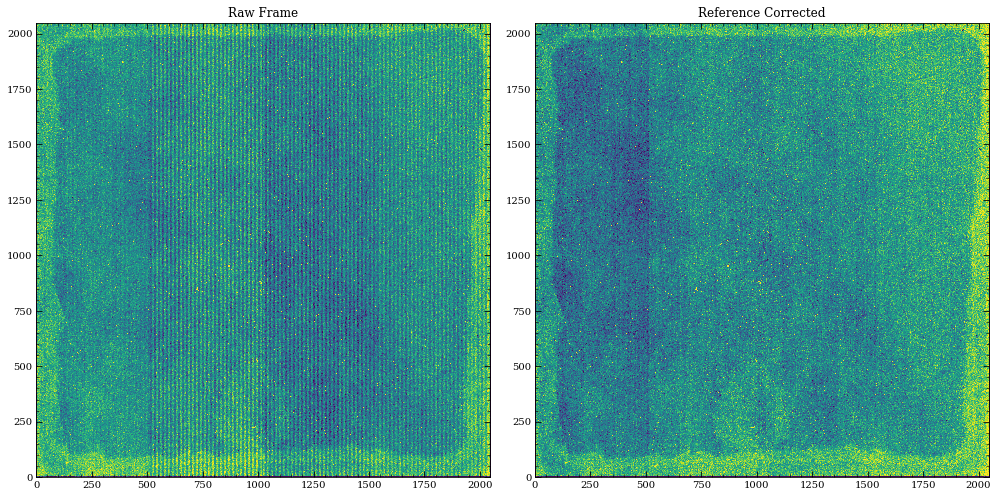

In [28]:
f = allfiles[2]
hdul = fits.open(f)
data = hdul[0].data.astype(np.float)
hdul.close()

data -= dark_data.super_bias

im1 = data[1] + dark_data.super_bias
data = ref_pixels.reffix_hxrg(data, **kwargs_ref)
im2 = data[1] + dark_data.super_bias

mn1 = np.median(im1)
mn2 = np.median(im2)

std1 = 3*robust.std(im1)
std2 = 3*robust.std(im2)

fig, axes = plt.subplots(1,2,figsize=(14,8))

ax = axes[0]
ax.imshow(im1, vmin=mn1-std1, vmax=mn1+std1)
ax.set_title("Raw Frame")

ax = axes[1]
ax.imshow(im2, vmin=mn2-std2, vmax=mn2+std2)
ax.set_title("Reference Corrected")

fig.tight_layout()

# if save_figs:
#     fig.savefig(outdir + "Raw_Image_Lin_{}.pdf".format(spd_str))
#     fig.savefig(outdir + "Raw_Image_Lin_{}.png".format(spd_str))

In [29]:
det.ref_info

array([4, 4, 4, 4])

In [45]:
# Determine saturation level in ADU (relative to bias)
def find_sat(data, bias=None, ref_info=[4,4,4,4]):

    # bias = super_bias0

    # Subtract bias?
    nz, ny, nx = data.shape
    imarr = data if bias is None else data - bias

    # Data can be characterized as large differences at start,
    # followed by decline and then difference of 0 at hard saturation

    # Determine difference between samples
    diff_arr = imarr[1:] - imarr[0:-1]

    # Select pixels to determine individual saturation values
    diff_max = np.median(diff_arr[0]) / 10
    diff_min = 100

    # Ensure a high rate at the beginning and a flat rate at the end
    sat_mask = (diff_arr[0]>diff_max) & (np.abs(diff_arr[-1]) < diff_min)

    # Median value to use for pixels that didn't reach saturation
    sat_med = np.median(imarr[-1][sat_mask])
    
    sat_arr = np.ones([ny,nx]) * sat_med
    sat_arr[sat_mask] = imarr[-1][sat_mask]

    # Reference pixels don't saturate
    # [lower, upper, left, right]
    br, ur, lr, rr = ref_info
    ref_mask = np.zeros([ny,nx], dtype=bool)
    ref_mask[0:br,:] = True
    ref_mask[-ur:,:] = True
    ref_mask[:,0:lr] = True
    ref_mask[:,-rr:] = True
    sat_arr[ref_mask] = 2**16-1
    
    return sat_arr


In [49]:
from pynrc.nrc_utils import jl_poly_fit, jl_poly

# Fit unsaturated sata and return coefficients
def cube_fit(tarr, data, bias=None, sat_vals=None, sat_frac=0.95, 
             deg=2, fit_zero=False, verbose=False, ref_info=[4,4,4,4],
             use_legendre=False, lxmap=None, return_lxmap=False):
        
    nz, ny, nx = data.shape
    
    # Subtract bias?
    imarr = data if bias is None else data - bias
    
    # Get saturation levels
    if sat_vals is None:
        sat_vals = find_sat(imarr, ref_info=ref_info)
        
    # Array of masked pixels (saturated)
    mask_good = imarr < sat_frac*sat_vals
    
    # Reshape for all pixels in single dimension
    imarr = imarr.reshape([nz, -1])
    mask_good = mask_good.reshape([nz, -1])

    # Initial 
    cf = np.zeros([deg+1, nx*ny])
    if return_lxmap:
        lx_min = np.zeros([nx*ny])
        lx_max = np.zeros([nx*ny])

    # For each 
    npix_sum = 0
    i0 = 0 if fit_zero else 1
    for i in np.arange(i0,nz)[::-1]:
        ind = (cf[1] == 0) & (mask_good[i])
        npix = np.sum(ind)
        npix_sum += npix
        
        if verbose:
            print(i+1,npix,npix_sum, 'Remaining: {}'.format(nx*ny-npix_sum))
            
        if npix>0:
            if fit_zero:
                x = np.concatenate(([0], tarr[0:i+1]))
                y = np.concatenate((np.zeros([1, np.sum(ind)]), imarr[0:i+1,ind]), axis=0)
            else:
                x, y = (tarr[0:i+1], imarr[0:i+1,ind])

            if return_lxmap:
                lx_min[ind] = np.min(x) if lxmap is None else lxmap[0]
                lx_max[ind] = np.max(x) if lxmap is None else lxmap[1]
                
            # Fit line if too few points relative to polynomial degree
            if len(x) <= deg+1:
                cf[0:2,ind] = jl_poly_fit(x,y, deg=1, use_legendre=use_legendre, lxmap=lxmap)
            else:
                cf[:,ind] = jl_poly_fit(x,y, deg=deg, use_legendre=use_legendre, lxmap=lxmap)

    imarr = imarr.reshape([nz,ny,nx])
    mask_good = mask_good.reshape([nz,ny,nx])
    
    cf = cf.reshape([deg+1,ny,nx])
    if return_lxmap:
        lxmap_arr = np.array([lx_min, lx_max]).reshape([2,ny,nx])
        return cf, lxmap_arr
    else:
        return cf


In [42]:
# Time array
tarr = np.arange(1, det.multiaccum.ngroup+1) * det.time_group

In [107]:
lxmap = [0,tarr.max()]
use_legendre = False

In [121]:
sat_vals = find_sat(data)
cf = cube_fit(tarr, data, sat_vals=sat_vals, sat_frac=0.98, fit_zero=False,
                         use_legendre=use_legendre, lxmap=lxmap, deg=2)

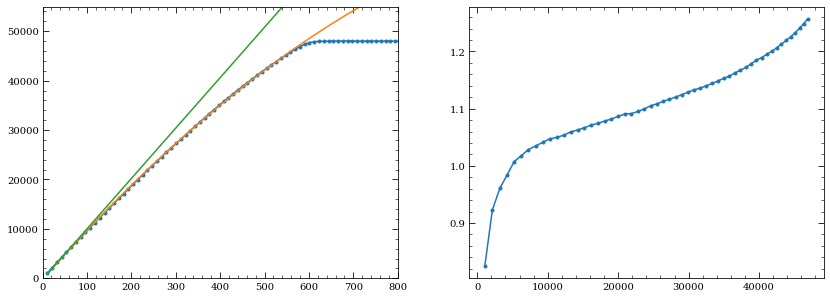

In [122]:
fig, axes = plt.subplots(1,2, figsize=(14,5))

ypix, xpix = (100,100)
pix_vals = data[:,ypix, xpix]
sat_lim = sat_vals[ypix, xpix]

ax = axes[0]
ax.plot(tarr, pix_vals, marker='.')
dfit = jl_poly(tarr, cf[:,ypix, xpix], use_legendre=use_legendre, lxmap=lxmap)
dfit_lin = jl_poly(tarr, cf[0:2,ypix, xpix], use_legendre=use_legendre, lxmap=lxmap)
ax.plot(tarr, dfit)
ax.plot(tarr, dfit_lin)

ax.set_xlim([0,800])
ax.set_ylim([0,55000])

ax = axes[1]
ind = pix_vals < (sat_lim*0.98)
frac = dfit_lin / pix_vals 
ax.plot(pix_vals[ind], frac[ind], marker='.')

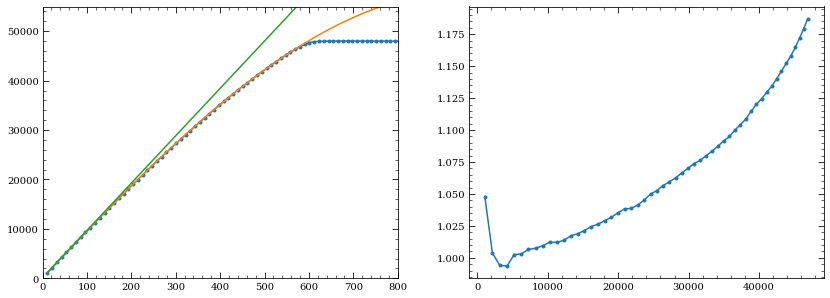

In [118]:
fig, axes = plt.subplots(1,2, figsize=(14,5))

ypix, xpix = (100,100)
pix_vals = data[:,ypix, xpix]
sat_lim = sat_vals[ypix, xpix]

ax = axes[0]
ax.plot(tarr, pix_vals, marker='.')
dfit = jl_poly(tarr, cf[:,ypix, xpix], use_legendre=use_legendre, lxmap=lxmap)
dfit_lin = jl_poly(tarr, cf[0:2,ypix, xpix], use_legendre=use_legendre, lxmap=lxmap)
ax.plot(tarr, dfit)
ax.plot(tarr, dfit_lin)

ax.set_xlim([0,800])
ax.set_ylim([0,55000])

ax = axes[1]
ind = pix_vals < (sat_lim*0.98)
frac = dfit_lin / pix_vals 
ax.plot(pix_vals[ind], frac[ind], marker='.')

In [76]:
from pynrc.maths.image_manip import hist_indices

In [87]:
vals = sat_vals
binsize = 10
bins = np.arange(sat_vals.min(), sat_vals.max() + binsize, binsize)
ig, vg, cv = hist_indices(vals, bins, return_more=True)

nvals = np.array([len(i) for i in ig])

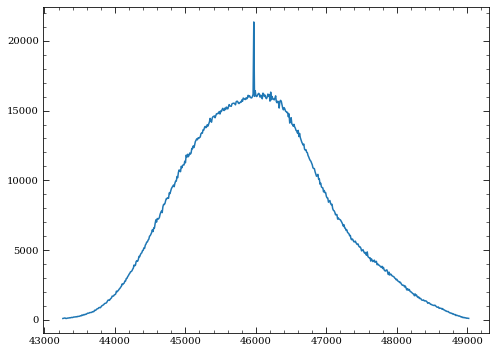

In [91]:
ind = (cv>0) & (cv<65000) & (nvals>100)
plt.plot(cv[ind], nvals[ind])

(0.0, 50000.0)

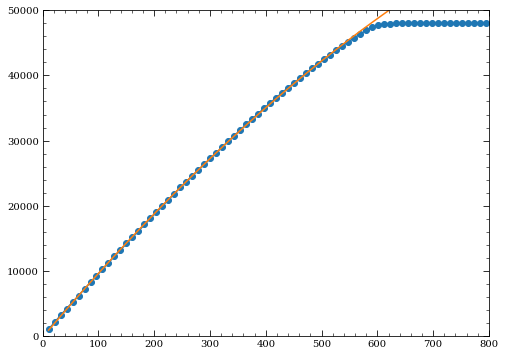

In [59]:
plt.plot(tarr, data[:,100,100], marker='o')

dfit = jl_poly(tarr, cf[:,100,100], use_legendre=True, lxmap=lxmap_arr[:,100,100])
plt.plot(tarr, dfit)

plt.xlim([0,800])
plt.ylim([0,50000])

[  10.73677   21.47354   32.21031   42.94708   53.68385   64.42062
   75.15739   85.89416   96.63093  107.3677   118.10447  128.84124
  139.57801  150.31478  161.05155  171.78832  182.52509  193.26186
  203.99863  214.7354   225.47217  236.20894  246.94571  257.68248
  268.41925  279.15602  289.89279  300.62956  311.36633  322.1031
  332.83987  343.57664  354.31341  365.05018  375.78695  386.52372
  397.26049  407.99726  418.73403  429.4708   440.20757  450.94434
  461.68111  472.41788  483.15465  493.89142  504.62819  515.36496
  526.10173  536.8385   547.57527  558.31204  569.04881  579.78558
  590.52235  601.25912  611.99589  622.73266  633.46943  644.2062
  654.94297  665.67974  676.41651  687.15328  697.89005  708.62682
  719.36359  730.10036  740.83713  751.5739   762.31067  773.04744
  783.78421  794.52098  805.25775  815.99452  826.73129  837.46806
  848.20483  858.9416   869.67837  880.41514  891.15191  901.88868
  912.62545  923.36222  934.09899  944.83576  955.57253  966.309